In [6]:
import RE16
import os
import time
import numpy as np
import matplotlib.pyplot as plt


In [7]:
def save(t, fr, file_path='simulation_results.dat', folder=None):
    """Save simulation results to a file.
    
    Args:
        file_path: Name of the file to save results to
        folder: Optional folder path for the file
    """
    if folder is not None:
        if not os.path.exists(folder):
            os.makedirs(folder)
        file_path = os.path.join(folder, file_path)

    with open(file_path, 'w') as file:
        for i in range(len(t)):
            row = f'{t[i]} '
            row += ' '.join([f'{fr[j,i]}' for j in range(fr.shape[0])])
            file.write(row + '\n')
            
    print(f'\n{time.strftime("%Y-%m-%d %H:%M:%S")}: file saved as {file_path}')
    
_eip_rg = {
    'original': [
        [1, 9, 0, 8],
        [1, 9, 10],
        [2, 10, 1],
        [2, 10, 11],
        [3, 11, 2],
        [3, 11, 12],
        [4, 12, 3],
        [4, 12, 13],
        [5, 13, 4],
        [5, 13, 14],
        [6, 14, 5],
        [6, 14, 15],
        [7, 15, 6],
        [7, 15, 16],
        [8, 16, 7],
        [8, 16, 17, 9]],
    'symmetry': [
        [0, 1, 17],
        [1, 17, 10],
        [1, 2, 10],
        [2, 10, 11],
        [2, 3, 11],
        [3, 11, 12],
        [3, 4, 12],
        [4, 12, 13],
        [4, 5, 13],
        [5, 13, 14],
        [5, 6, 14],
        [6, 14, 15],
        [6, 7, 15],
        [7, 15, 16],
        [7, 0, 16],
        [0, 16, 17]]
}

_WEIGHT_MATRICES = {}
for circuit, groups in _eip_rg.items():
    W = np.zeros((18, len(groups)), dtype=float)
    for j, idx_list in enumerate(groups):
        w = 1.0 / len(idx_list)
        W[idx_list, j] = w
    _WEIGHT_MATRICES[circuit] = W

def eip_to_eb_fast(eip_fr: np.ndarray, circuit: str = 'symmetry') -> np.ndarray:
    eip = np.asarray(eip_fr)
    W = _WEIGHT_MATRICES[circuit]
    eb_fr = eip.dot(W)
    return eb_fr

def plot_original(t, fr, title=None, file_name=None, region='EB', y_label='Time (s)', cmap='Blues', 
            save=False, folder='figures', plot_gau=True, figsize=(10, 2.5), eip2eb=True):
    
    if eip2eb:
        fr_with_zeros = np.zeros((fr.shape[0], fr.shape[1] + 2))
        fr_with_zeros[:, :8] = fr[:, :8]
        fr_with_zeros[:, 10:] = fr[:, 8:]
        eb_fr = eip_to_eb_fast(fr_with_zeros)
        eb_fr = eb_fr.T
    else:
        eb_fr = fr
        
    plt.figure(figsize=figsize)
    plt.pcolormesh(t, [i for i in range(eb_fr.shape[0])], eb_fr, cmap=cmap, shading='nearest')
    plt.colorbar(label='Firing Rate [Hz]')    
    plt.title(title)
    plt.xlabel(y_label)
    plt.ylabel('EB region' if region == 'EB' else 'Neuron ID')
    plt.yticks([0, 4, 11, 15], ['R8', 'R4', 'L4', 'L8'] if region == 'EB' else [0, 5, 10, 15])

def load(file_path='simulation_results.dat'):
    """Load simulation results from a file.
    
    Args:
        file_path: Path to the file containing simulation results
    """
    # Use numpy for efficient file loading
    data = np.loadtxt(file_path)
    t = data[:, 0]
    fr = data[:, 1:]  # EIP0 - EIP17
    
    # Insert zeros at positions 8 and 9 (missing neurons)
    fr_with_zeros = np.zeros((fr.shape[0], fr.shape[1] + 2))
    fr_with_zeros[:, :8] = fr[:, :8]
    fr_with_zeros[:, 10:] = fr[:, 8:]

    return t, fr.T

In [8]:
t, fr, fr_v = RE16.simulator(w_EE = 0.719, # EB <-> EB
                            w_EI = 0.143, # R -> EB 0.143
                            w_IE = 0.740, # EB -> R 0.740
                            w_II = 0.01, # R <-> R
                            w_PP = 0.01, # PEN <-> PEN
                            w_EP = 0.012, # EB -> PEN 
                            w_PE = 0.709, # PEN -> EB
                            shifter_strength=0.,
                            shifter_strength_v=0.017,
                            half_PEN='right')

start
Creating EPG-EPG connections...
Creating PEN-PEN connections...
Creating EPG-R connections...
Creating R-EPG connections...
Creating R-R connections...
Creating EPG-PEN connections...
Creating PEN0-6 -> EPG0-8 connections (PE2R)...
Creating PEN0-6 -> EPG0-8 connections (PE1R)...
Creating  PE1R connection...
Creating PEN9-15 -> EPG0-8 connections (PE2R2)...
Creating PEN9-15 -> EPG0-8 connections (PE1R2)...
Creating  PE1R2 connection...
Creating PEN7 connections...
Creating PEN8 connections...
Creating PEN0-6 -> EPG8-15 connections (PE2L)...
Creating PEN0-6 -> EPG8-15 connections (PE1L)...
Creating  PE1L connection...
Creating PEN9-15 -> EPG8-15 connections (PE2L2)...
Creating PEN9-15 -> EPG8-15 connections (PE1L2)...
Creating  PE1L2 connection...
vertical connections
Creating EPGv-EPGv connections...
Creating PENv-PENv connections...
Creating EPGv-R connections...
Creating R-EPGv connections...
Creating EPGv-PENv connections...
Creating PENv0-6 -> EPGv0-8 connections (PE2Rv)...
Cr

In [9]:
save(t, fr, 'h.dat')
save(t, fr_v, 'v.dat')


2025-06-15 10:52:40: file saved as h.dat

2025-06-15 10:52:41: file saved as v.dat


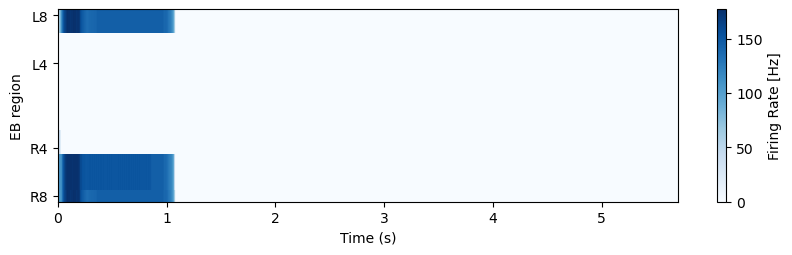

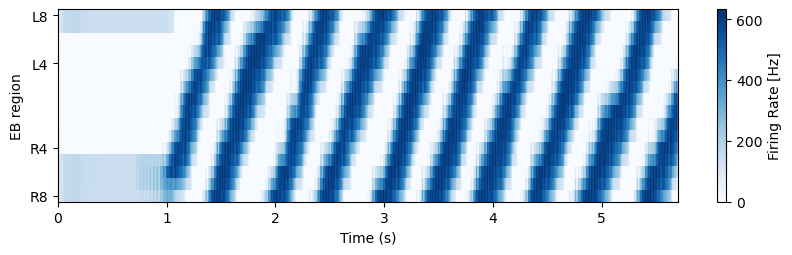

In [10]:
t, fr = load('h.dat')
plot_original(t, fr.T)

t, fr_v = load('v.dat')
plot_original(t, fr_v.T)
